# Multi-class Image Classification

This tutorial is based on the [TensorFlow Image Classification](https://www.tensorflow.org/tutorials/images/classification) with some modifications, which shows how to classify images of fingerprints using a tf.keras.Sequential model and load data using tf.keras.utils.image_dataset_from_directory. It demonstrates the following concepts:

1. Efficiently loading a dataset off disk.
1. Identifying overfitting and applying techniques to mitigate it, including data augmentation and dropout.

This tutorial follows a basic machine learning workflow:

1. Examine and understand data
1. Build an input pipeline
1. Build the model
1. Train the model
1. Test the model
1. Improve the model and repeat the process

In addition, there is a secondary notebook that demonstrates how to convert a saved model to a TensorFlow Lite model for on-device machine learning on mobile, embedded, and IoT devices.

## Setup

Import TensorFlow and other necessary libraries:

In [45]:
! pip install -r ../requirements.txt -q

In [46]:
import tensorflow as tf
import tensorflow_datasets as tfds
import PIL
import PIL.Image
import numpy as np
import pandas as pd
import os
import glob
import cv2

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
from IPython.display import display
import plotly.graph_objects as go


# Load the TensorBoard notebook extension.
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Check TF and Cuda versions

For reference [see this chart](https://www.tensorflow.org/install/source#gpu)

In [47]:
# check versions for Tensorflow and Cuda
print('TensorFlow: ' + tf.__version__)
print('TensorFlow Datasets: ' + tfds.__version__)
print('OpenCV version: ' + cv2.__version__)

# Check CUDA Version
sys_details = tf.sysconfig.get_build_info()
cuda_version = sys_details["cuda_version"]
print('Cuda version: ' + cuda_version)

# Check CUDNN Version
cudnn_version = sys_details["cudnn_version"]  
print('cudnn version: ' + cudnn_version)

TensorFlow: 2.14.0
TensorFlow Datasets: 4.9.3
OpenCV version: 4.8.1
Cuda version: 11.8
cudnn version: 8


In [48]:
# scratch directory is apart of the .gitignore to ensure it is not committed to git
%env SCRATCH=../scratch
! [ -e "${SCRATCH}" ] || mkdir -p "${SCRATCH}"

scratch_path = os.environ.get('SCRATCH', './scratch')

env: SCRATCH=../scratch


# Create dataset

Define some parameters for the loader

In [49]:
batch_size = 32
img_height = 96
img_width = 96

## Create the training dataset

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [54]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  scratch_path + '/processed/',
  #color_mode="grayscale",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 53860 files belonging to 9 classes.
Using 43088 files for training.


## Create the validation dataset

In [55]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  scratch_path + '/processed/',
  #color_mode="grayscale",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 53860 files belonging to 9 classes.
Using 10772 files for validation.


## Print the inferred class names

You can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.

In [56]:
class_names = train_ds.class_names
print(class_names)

['female', 'index', 'left', 'little', 'male', 'middle', 'right', 'ring', 'thumb']


## Visualize the data

Here are the first nine images from the training dataset with their corresponding labels.

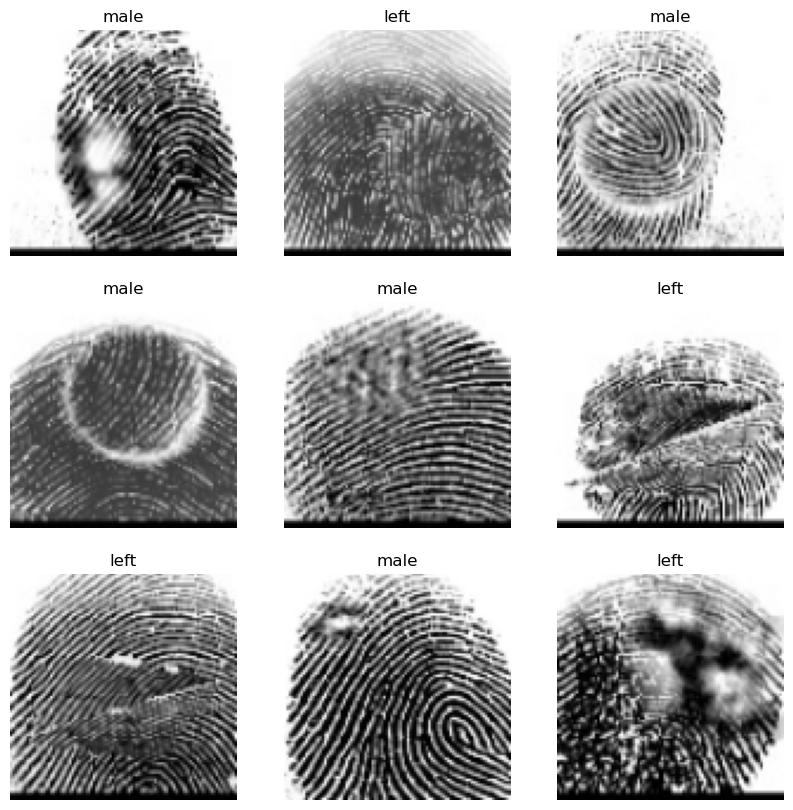

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Pass the datasets to the Keras Model.fit method for training in later steps.

Use the image_batch tensor of  shape (32, 96, 96, 3), which splits batch of 32 images of shape 96x96x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

In [65]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 96, 96, 3)
(32,)


## Configure the dataset for performance

We can use buffered prefetching, to yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

1. `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
1. `Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [66]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [67]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [68]:
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 4


In [69]:
# cuda_malloc_async has fewer fragmentation issues than the default BFC memory allocator - https://docs.nvidia.com/deeplearning/frameworks/tensorflow-user-guide/index.html#tf_gpu_allocator
TF_FORCE_GPU_ALLOW_GROWTH=True

os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
print(os.getenv("TF_GPU_ALLOCATOR"))

cuda_malloc_async


In [70]:
num_classes = len(class_names)
input_image_shape = (96, 96, 1)

with strategy.scope():
    model = Sequential([
      layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(num_classes)
    ])

In [71]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [72]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 conv2d_15 (Conv2D)          (None, 96, 96, 16)        448       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 48, 48, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 48, 48, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 24, 24, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 24, 24, 64)       

In [73]:
epochs=10

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
INFO:tensorflow:Collective all_reduce tensors: 10 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 10 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 10 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


INFO:tensorflow:Collective all_reduce tensors: 10 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1


1347/1347 [==============================] - 19s 11ms/step - loss: 1.8513 - accuracy: 0.2792 - val_loss: 1.7619 - val_accuracy: 0.2884
Epoch 2/10
1347/1347 [==============================] - 14s 11ms/step - loss: 1.7039 - accuracy: 0.2961 - val_loss: 1.6783 - val_accuracy: 0.2846
Epoch 3/10
1347/1347 [==============================] - 15s 11ms/step - loss: 1.6297 - accuracy: 0.3009 - val_loss: 1.6535 - val_accuracy: 0.2778
Epoch 4/10
1347/1347 [==============================] - 14s 11ms/step - loss: 1.5643 - accuracy: 0.3067 - val_loss: 1.6129 - val_accuracy: 0.2735
Epoch 5/10
1347/1347 [==============================] - 14s 11ms/step - loss: 1.4988 - accuracy: 0.3114 - val_loss: 1.6299 - val_accuracy: 0.2472
Epoch 6/10
1347/1347 [==============================] - 14s 11ms/step - loss: 1.4371 - accuracy: 0.3149 - val_loss: 1.6273 - val_accuracy: 0.2315
Epoch 7/10
1347/1347 [==============================] - 14s 11ms/step - loss: 1.3887 - accuracy: 0.3173 - val_loss: 1.6314 - val_accura

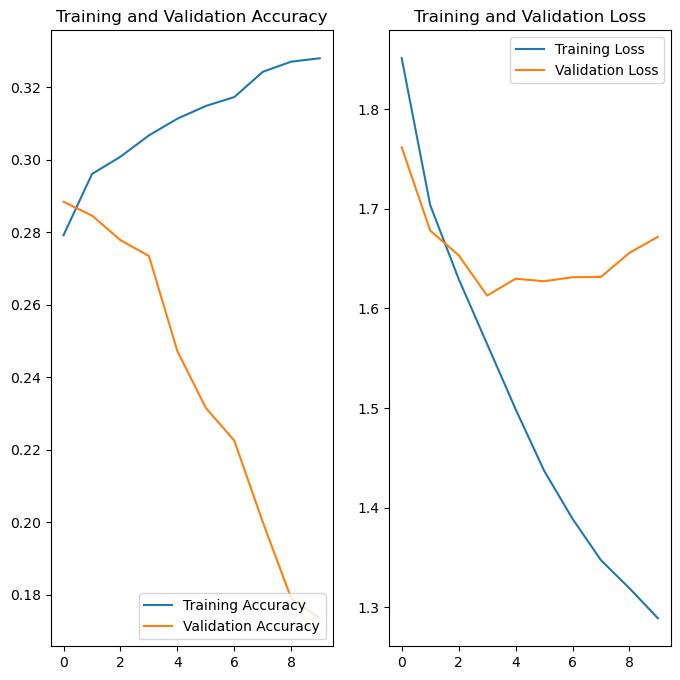

In [74]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Serialize Model

In [75]:
# note: tf.saved_model.save(model, path_to_dir)
model_version = os.environ.get('VERSION', "1")


model_path = "../models/fingerprint/" + model_version + "/model.savedmodel"
model.save(model_path)

INFO:tensorflow:Assets written to: ../models/fingerprint/1/model.savedmodel/assets


INFO:tensorflow:Assets written to: ../models/fingerprint/1/model.savedmodel/assets


In [76]:
fingerprint = scratch_path + "/train/index/1__M_Left_index_finger_CR.png"

img = tf.keras.utils.load_img(
    fingerprint, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 1s 788ms/step
This image most likely belongs to male with a 47.45 percent confidence.
